# Lib Import

In [1]:
import cv2
import json 
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Method

In [2]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        # csv 파일형태로 입력받음 
        file = self.files[i]
        # file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            # csv_path = f'{file}/{file_name}.csv'
            # df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = pd.read_csv(file)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        # image_path = f'{file}/{file_name}.jpg'
        image_path = file.replace("csv", "jpg")
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            # json_path = f'{file}/{file_name}.json'
            json_path = file.replace("csv", "json")
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

In [22]:
# Model output 평가 메서드
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='micro')
    return score

# Model 훈련 메서드 
def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
        
    # 평가 모드일 때 eval()을 통해 가중치를 update하지 않음
    else:
        model.eval()                         
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

# Data Load

In [18]:
# json 파일을 로드하여 레이블데이터 추출
csv_files = glob("./three_series_train/*/*.csv")    # 생육정보 csv파일 
json_files = glob("./three_series_train/*/*.json")  # 레이블 정보가 담긴 파일

train_label = []

for i in range(len(json_files)):
    json_file = json_files[i]
    
    with open(json_file, 'r') as f:
        tmp_json = json.load(f)
        
    crop = tmp_json['annotations']['crop']
    disease = tmp_json['annotations']['disease']
    risk = tmp_json['annotations']['risk']
    label = f'{crop}_{disease}_{risk}'
    
    train_label.append(label)

In [19]:
# train / validation / test  데이터 분할
X_train, X_test, y_train, y_test = train_test_split(csv_files, train_label, test_size=0.2, shuffle=True, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)

print(len(X_train), len(X_val), len(X_test))

830 357 297


In [20]:
# 생육정보 csv 파일의 MinMax scaling data 

csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                    '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

# feature별 최댓값 최솟값 계산
for idx, csv in tqdm(enumerate(X_train)):

    if idx == 0:
        temp_csv = pd.read_csv(csv)[csv_features]
        temp_csv = temp_csv.replace('-', np.nan).dropna()
        max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy() 

    else:
        temp_csv = pd.read_csv(csv)[csv_features]
        temp_csv = temp_csv.replace('-', np.nan).dropna()
        if len(temp_csv) == 0:
            continue
        temp_csv = temp_csv.astype(float)
        temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
        max_arr, min_arr = np.max([max_arr, temp_max], axis = 0), np.min([min_arr, temp_min], axis = 0)

# feature 별 최대값, 최솟값 dictionary 생성 
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

830it [00:02, 352.46it/s]


{'내부 온도 1 평균': [13.9, 30.7],
 '내부 온도 1 최고': [14.0, 30.7],
 '내부 온도 1 최저': [13.9, 30.6],
 '내부 습도 1 평균': [41.5, 97.2],
 '내부 습도 1 최고': [42.3, 97.2],
 '내부 습도 1 최저': [40.5, 97.2],
 '내부 이슬점 평균': [12.2, 23.8],
 '내부 이슬점 최고': [12.2, 24.6],
 '내부 이슬점 최저': [12.1, 23.1]}

# Model

In [23]:
"""
- CNN과 RNN은 각각 이미지와 생육환경정보(.csv)데이터를 입력으로 받아 
  인코더 역할을 수행함
- 이 후 CNN2RNN 모델에서 각각의 output을 concat하여 fc layer을 거쳐 
  분류되게됨
- CNN Encoder와 RNN Encoder는 각각 output 으로 1000 차원의 데이터를 내뱉음 
- 이후 CNN2RNN 모델을 통해 해당 모데들의 output을 concat 하여  
  fc layer를 통해  classfying 을 진행 
"""
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
       
    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        output = self.rnn_fc(hidden)
        
        return output

class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        self.embedding_layer = nn.Linear(1000 + 1000, 784)
        self.final_layer = nn.Linear(784, class_n)
        self.dropout1 = nn.Dropout(rate)
        self.dropout2 = nn.Dropout(rate)
        self.relu = nn.ReLU()
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        rnn_output = self.rnn(cnn_output, seq)
        concat = torch.cat([cnn_output, rnn_output], dim=1)
        fc_input = concat
        output = self.dropout1(self.embedding_layer(fc_input))
        output = self.relu(output)
        output = self.dropout2(self.final_layer(output))
        
        return output

# Script 

In [24]:
# 레이블 인코더 / 디코더 정의 
label_decoder = {0: '3_00_0', 1: '3_a9_1', 2: '3_a9_2', 3: '3_a9_3'}
label_encoder = {'3_00_0': 0, '3_a9_1': 1, '3_a9_2': 2, '3_a9_3': 3}

In [25]:
# 하이퍼 파라미터
device = ("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 10
vision_pretrain = True

In [26]:
# 데이터 로더 구현 
train_dataset = CustomDataset(X_train)
val_dataset = CustomDataset(X_val)
test_dataset = CustomDataset(X_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

In [27]:
# 모델 로드 
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
# weigth decay 조건에 맞게 수행시켜주는 모듈 
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', verbose=True, patience=3, factor=0.5)

In [28]:
# 훈련 진행 
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))

    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))

    scheduler.step(total_val_loss/(batch+1))
    
     # validation f1 스코어가 높으면 모델 저장수행
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), f"./model_save/{model._get_name()}.pt")
        torch.save(model.state_dict(), f"./model_save/{model._get_name()}.pth")
    

7it [00:02,  2.53it/s, Epoch=1, Loss=0.448938, Mean Loss=0.720093, Mean F-1=0.713494]
3it [00:01,  2.13it/s, Epoch=1, Val Loss=0.465939, Mean Val Loss=0.468516, Mean Val F-1=0.807782]
7it [00:02,  2.69it/s, Epoch=2, Loss=0.174129, Mean Loss=0.225953, Mean F-1=0.919355]
3it [00:01,  2.21it/s, Epoch=2, Val Loss=0.324055, Mean Val Loss=0.302211, Mean Val F-1=0.875670]
7it [00:02,  2.71it/s, Epoch=3, Loss=0.128483, Mean Loss=0.123417, Mean F-1=0.957301]
3it [00:01,  2.22it/s, Epoch=3, Val Loss=0.411346, Mean Val Loss=0.377335, Mean Val F-1=0.883483]
7it [00:02,  2.68it/s, Epoch=4, Loss=0.045684, Mean Loss=0.046212, Mean F-1=0.991071]
3it [00:01,  2.17it/s, Epoch=4, Val Loss=0.467874, Mean Val Loss=0.410818, Mean Val F-1=0.902408]
7it [00:02,  2.68it/s, Epoch=5, Loss=0.014749, Mean Loss=0.038120, Mean F-1=0.989955]
3it [00:01,  2.17it/s, Epoch=5, Val Loss=0.490345, Mean Val Loss=0.415715, Mean Val F-1=0.907101]
7it [00:02,  2.68it/s, Epoch=6, Loss=0.026065, Mean Loss=0.027003, Mean F-1=0.99

Epoch     6: reducing learning rate of group 0 to 5.0000e-05.


7it [00:02,  2.65it/s, Epoch=7, Loss=0.025267, Mean Loss=0.020724, Mean F-1=0.996652]
3it [00:01,  2.20it/s, Epoch=7, Val Loss=0.574323, Mean Val Loss=0.494070, Mean Val F-1=0.905709]
7it [00:02,  2.71it/s, Epoch=8, Loss=0.023323, Mean Loss=0.017683, Mean F-1=0.995536]
3it [00:01,  2.19it/s, Epoch=8, Val Loss=0.595154, Mean Val Loss=0.517665, Mean Val F-1=0.903104]
7it [00:02,  2.68it/s, Epoch=9, Loss=0.001272, Mean Loss=0.020408, Mean F-1=0.994420]
3it [00:01,  2.21it/s, Epoch=9, Val Loss=0.575022, Mean Val Loss=0.504613, Mean Val F-1=0.894596]
7it [00:02,  2.66it/s, Epoch=10, Loss=0.024442, Mean Loss=0.020162, Mean F-1=0.998884]
3it [00:01,  2.20it/s, Epoch=10, Val Loss=0.603320, Mean Val Loss=0.500953, Mean Val F-1=0.903801]

Epoch    10: reducing learning rate of group 0 to 2.5000e-05.


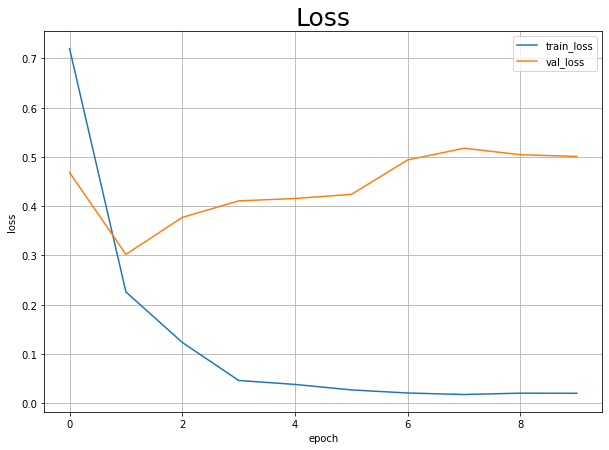

In [29]:
# 훈련 결과 시각화 
# Loss 추이 시각화

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(torch.Tensor(loss_plot).cpu(), label='train_loss')
plt.plot(torch.Tensor(val_loss_plot).cpu(), label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

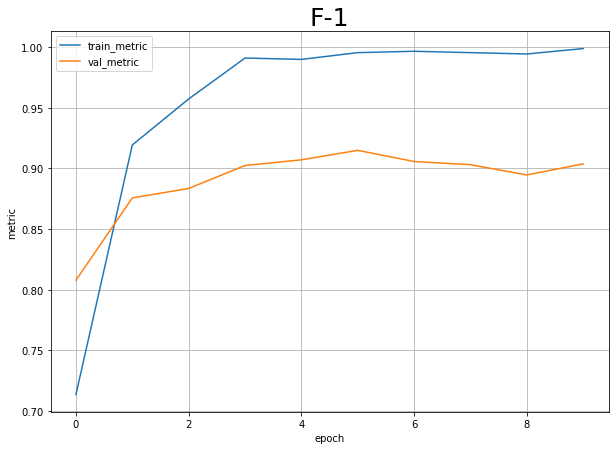

In [30]:
# 훈련 결과 시각화 
# F1 Score 추이 시각화

plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

In [31]:
# 모델 평가 
# 가장 좋은 F1 score를 냈던 모델을 로드

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model.load_state_dict(torch.load("./model_save/CNN2RNN.pt", map_location=device))
model.to(device)
model.eval()

total_test_acc = 0
total_test_precision = 0
total_test_recall = 0
total_test_f1 = 0

tqdm_dataset = tqdm(enumerate(test_dataloader))
for batch, batch_item in tqdm_dataset:
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    
    with torch.no_grad():
        output = model(img, csv_feature)
        
    real = label.cpu()
    pred = torch.argmax(output, dim=1).cpu()
        
    test_accuracy = accuracy_score(real, pred)
    test_precision = precision_score(real, pred, average='micro')
    test_recall = recall_score(real, pred, average='micro')
    test_f_1 = f1_score(real, pred, average='micro')
    
    total_test_acc+=test_accuracy
    total_test_precision+=test_precision
    total_test_recall+=test_recall
    total_test_f1+=test_f_1
    
test_acc = total_test_acc/(batch+1)
test_precision = total_test_precision/(batch+1)
test_recall = total_test_recall/(batch+1)
test_f1 = total_test_f1/(batch+1)

result_dict = dict()

result_dict['accuracy'] = test_acc
result_dict['avg_recall'] = test_recall
result_dict['avg_precision'] = test_precision
result_dict['avg_f1_score'] = test_f1

test_log = " Total_Acc : {:0.4f} | Total_f1 : {:0.4f} | Total Precision & Recall : {:0.4f} & {:0.4f} ".format(test_acc, test_f1, test_precision, test_recall)
print(test_log)


3it [00:01,  2.28it/s]

 Total_Acc : 0.9024 | Total_f1 : 0.9024 | Total Precision & Recall : 0.9024 & 0.9024 
